In [1]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as pdsql
%matplotlib inline

In [2]:
data = pd.read_csv('Downloads/LH_data_scientist_intern_excercise.csv')

In [3]:
data.head()

,property_id,transaction_amount,loan_amount,buyer,lender,transaction_date,property_type,property_address,seller,year_built,sqft
0,27885942,670000,0.0,"SWEENEY,THOMAS R & MICHELLE H",* Undisclosed,2012-02-27,RCON,NaN,FRIEDMAN H A & J H TRUST,1993,2682
1,26400001,260000,0.0,"DOUGHERTY,HERBERT III & JENNIFER M",* Undisclosed,2012-04-12,RSFR,NaN,C & M INVESTMENT GROUP INC,1984,1452
2,31540676,190000,0.0,WEST COAST RLTY SVCS INC,* Undisclosed,2012-04-18,RSFR,NaN,FEDERAL HOME LOAN MTG CORP,1903,1891
3,23913396,136500,0.0,"LOVE,JULIE M",* Undisclosed,2012-04-27,RSFR,NaN,"TERPSTRA,MIKE",1994,1147
4,28597691,21500,0.0,"SAHAR,DAVID",* Undisclosed,2012-05-09,VRES,NaN,BANK OF AMERICA NA,1977,1462


## Extracting Features and creating interaction terms

Converting string transaction date to datetime object and extracting zip code from property address

In [4]:
data['transaction_datetime'] = data.apply(lambda x: parse(x.transaction_date),axis=1)
data['zip_code'] = data.apply(lambda x: int(x.property_address.split()[-1][:5]) if x.property_address is not np.nan and x.property_address.split()[-1][:5] != 'CA' else np.nan, axis=1)

Extracting month, year and month,year from transaction datetime

In [5]:
data['month'] = data.apply(lambda x: x.transaction_datetime.month,axis=1)
data['year'] = data.apply(lambda x: x.transaction_datetime.year,axis=1)
data['month_year'] = data.apply(lambda x: 1000*x.year + x.month,axis=1)

In [6]:
def quarter(x):
    
    '''A function to define the quarters of a year from transaction date. Quarter 1 starts from Jan'''
    
    if x.month in [1,2,3]:
        return 1000*x.year + 1
    elif x.month in [4,5,6]:
        return 1000*x.year + 2
    elif x.month in [7,8,9]:
        return 1000*x.year + 3
    else:
        return 1000*x.year + 4

In [7]:
def loan_bracket(x):
    
    '''A function to classify loan amounts into buckets for easy analysis'''
    
    if x.loan_amount < 250000:
        return '< 250,000'
    elif x.loan_amount >= 250000 and x.loan_amount < 500000:
        return '250,001 to 500,000'
    elif x.loan_amount >= 500000 and x.loan_amount < 750000:
        return '500,001 to 750,000'
    elif x.loan_amount >= 750000 and x.loan_amount < 1000000:
        return '750,001 to 1,000,000'
    elif x.loan_amount >= 1000000 and x.loan_amount < 1500000:
        return '1,000,001 to 1,500,000'
    else:
        return '> 1,500,000'

In [8]:
data['quarter'] = data.apply(lambda x: quarter(x),axis=1)

In [9]:
data['loan_brackets'] = data.apply(lambda x: loan_bracket(x),axis=1)

An overview of the loan buckets

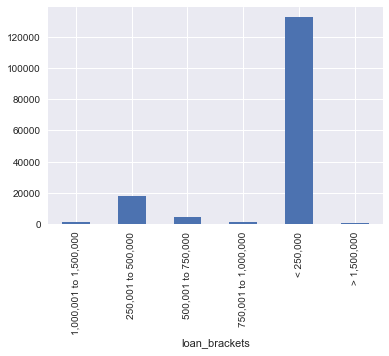

In [10]:
data.groupby('loan_brackets')['loan_amount'].count().plot(kind='bar')

#### LTT- It is the ratio of the loan amount to the transaction amount. We are using this to try to determine if there are any anomalies in the loan amoutn or transaction amount

In [11]:
data['LTT'] = data.apply(lambda x: x.loan_amount/x.transaction_amount \
                         if x.loan_amount > 0 and  x.transaction_amount > 0 else 0, axis=1)

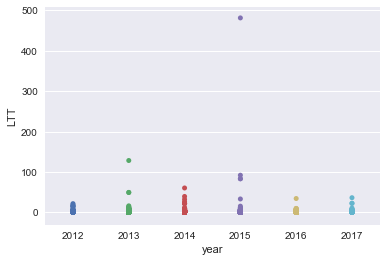

In [12]:
sns.stripplot(x='year',y='LTT',data=data)

## Extracting zip codes from file

*The zip code mapping was taken from here- http://www.zipcodestogo.com/California/ *

In [13]:
zipcodes = pd.read_csv('zip_codes_city_county.csv')

In [14]:
zipcodes.head()

,Zip Code,City,County
0,90001,Los Angeles,Los Angeles
1,90002,Los Angeles,Los Angeles
2,90003,Los Angeles,Los Angeles
3,90004,Los Angeles,Los Angeles
4,90005,Los Angeles,Los Angeles


In [15]:
zipcodes.columns = ['zip_code','city','county']

In [16]:
intermediate_data = data.merge(zipcodes, on='zip_code',how='left')

Sanity check- to see if the dataframes have merged properly

In [17]:
intermediate_data.head()

,property_id,transaction_amount,loan_amount,buyer,lender,transaction_date,property_type,property_address,seller,year_built,...,transaction_datetime,zip_code,month,year,month_year,quarter,loan_brackets,LTT,city,county
0,27885942,670000,0.0,"SWEENEY,THOMAS R & MICHELLE H",* Undisclosed,2012-02-27,RCON,NaN,FRIEDMAN H A & J H TRUST,1993,...,2012-02-27,NaN,2,2012,2012002,2012001,"< 250,000",0.0,NaN,NaN
1,26400001,260000,0.0,"DOUGHERTY,HERBERT III & JENNIFER M",* Undisclosed,2012-04-12,RSFR,NaN,C & M INVESTMENT GROUP INC,1984,...,2012-04-12,NaN,4,2012,2012004,2012002,"< 250,000",0.0,NaN,NaN
2,31540676,190000,0.0,WEST COAST RLTY SVCS INC,* Undisclosed,2012-04-18,RSFR,NaN,FEDERAL HOME LOAN MTG CORP,1903,...,2012-04-18,NaN,4,2012,2012004,2012002,"< 250,000",0.0,NaN,NaN
3,23913396,136500,0.0,"LOVE,JULIE M",* Undisclosed,2012-04-27,RSFR,NaN,"TERPSTRA,MIKE",1994,...,2012-04-27,NaN,4,2012,2012004,2012002,"< 250,000",0.0,NaN,NaN
4,28597691,21500,0.0,"SAHAR,DAVID",* Undisclosed,2012-05-09,VRES,NaN,BANK OF AMERICA NA,1977,...,2012-05-09,NaN,5,2012,2012005,2012002,"< 250,000",0.0,NaN,NaN


### County region mapping

*taken from here- http://www.cdss.ca.gov/research/res/pdf/multireports/RegionsofCalifornia.pdf
California Technology, Trade & Commerce Agency (9 regions) section*

In [18]:
county_region = pd.read_csv('county_region.csv')

In [19]:
#sanity check
county_region.head()

,County,Region
0,Del Norte,Northern California
1,Humboldt,Northern California
2,Lake,Northern California
3,Lassen,Northern California
4,Mendocino,Northern California


In [20]:
county_region.columns = ['county','region']

In [21]:
overall_data = intermediate_data.merge(county_region,on='county',how='left')

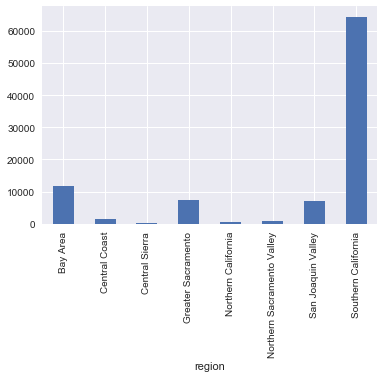

In [22]:
overall_data.groupby('region')['transaction_amount'].count().plot(kind='bar')

In [23]:
overall_data.region.loc[overall_data.region.isnull()] = 'Other'

/Users/chinnu/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


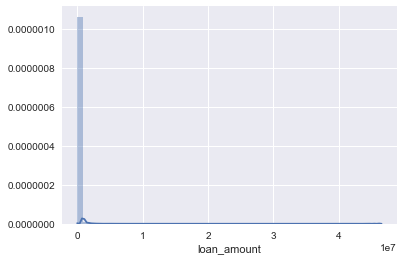

In [24]:
sns.distplot(overall_data.loan_amount)

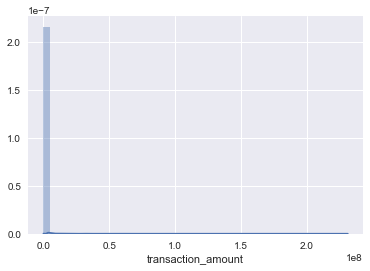

In [25]:
sns.distplot(overall_data.transaction_amount)

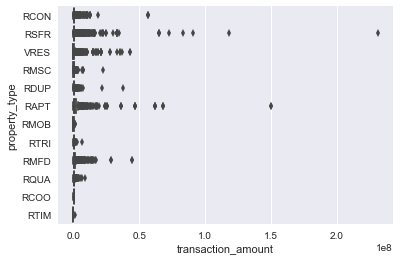

In [26]:
sns.boxplot(x='transaction_amount',y='property_type',data=overall_data)

Since most of the loan and transaction amounts are below the 2 million dollars, lets filter the transaction amounts to below 2 million and see how many data points are affected by the filter

In [27]:
loans_below_2mil = overall_data.loc[overall_data.loan_amount <= 2000000]

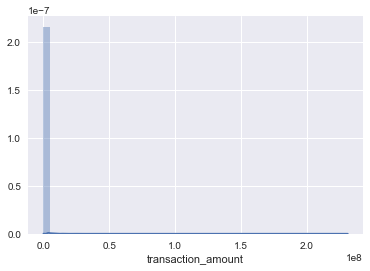

In [28]:
sns.distplot(loans_below_2mil.transaction_amount)

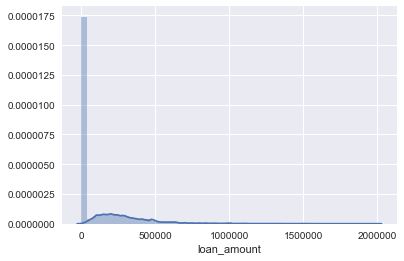

In [29]:
sns.distplot(loans_below_2mil.loan_amount)

In [30]:
transactions_below_2mil = overall_data.loc[overall_data.transaction_amount <= 2000000]

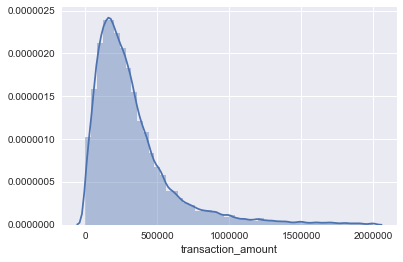

In [31]:
sns.distplot(transactions_below_2mil.transaction_amount)

Even after filtering for transactions below 2 million, we see that there are very few transactions above 1.5 million 

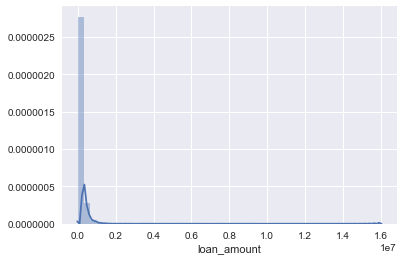

In [32]:
sns.distplot(transactions_below_2mil.loan_amount)

In [33]:
loans_above_2mil = len(overall_data.loc[overall_data.loan_amount > 2000000])
loans_above_2mil

391

In [34]:
transactions_above_2mil = len(overall_data.loc[overall_data.transaction_amount > 2000000])
transactions_above_2mil

2221

Checking how many loans LendingHome has given out that are above 2mill

In [35]:
overall_data.loc[(overall_data.loan_amount > 2000000) & (overall_data.lender=='LendingHome')]

,property_id,transaction_amount,loan_amount,buyer,lender,transaction_date,property_type,property_address,seller,year_built,...,zip_code,month,year,month_year,quarter,loan_brackets,LTT,city,county,region
119127,29989553,2185100,2087700.0,NORTH POINT INVESTMENT PARTNER,LendingHome,2015-10-07,RSFR,MONTE VERDE 4 SW OF 13TH CARMEL CA 93921,"DEL CASTELLO,MICHAEL & PATRICIA",1937,...,93921,10,2015,2015010,2015004,"> 1,500,000",0.955425,Carmel By The Sea,Monterey,Central Coast


Checking how many trasaction are above 2mill with LendingHome

In [36]:
overall_data.loc[(overall_data.transaction_amount > 2000000) & (overall_data.lender=='LendingHome')]

,property_id,transaction_amount,loan_amount,buyer,lender,transaction_date,property_type,property_address,seller,year_built,...,zip_code,month,year,month_year,quarter,loan_brackets,LTT,city,county,region
54017,32172190,3450182,306000.0,SJU INVESTMENT HOLDINGS INC,LendingHome,2015-08-14,RSFR,15302 CABELL AVE BELLFLOWER CA 90706,"NILANUT,ANURAK",1952,...,90706,8,2015,2015008,2015003,"250,001 to 500,000",0.088691,Bellflower,Los Angeles,Southern California
119127,29989553,2185100,2087700.0,NORTH POINT INVESTMENT PARTNER,LendingHome,2015-10-07,RSFR,MONTE VERDE 4 SW OF 13TH CARMEL CA 93921,"DEL CASTELLO,MICHAEL & PATRICIA",1937,...,93921,10,2015,2015010,2015004,"> 1,500,000",0.955425,Carmel By The Sea,Monterey,Central Coast


In [37]:
overall_data.transaction_amount.max()

231000000

In [39]:
overall_data = overall_data.loc[overall_data.transaction_amount < 231000000 ].copy()

### Adding more interaction terms

Finding out if a buyer is an investment firm or individual(s)

In [40]:
overall_data['is_company'] = overall_data.apply(lambda x: 1 if ',' not in x.buyer else 0, axis=1)

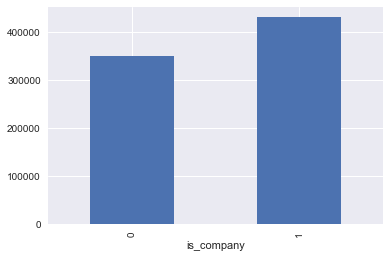

In [41]:
overall_data.groupby('is_company')['transaction_amount'].mean().plot(kind='bar')

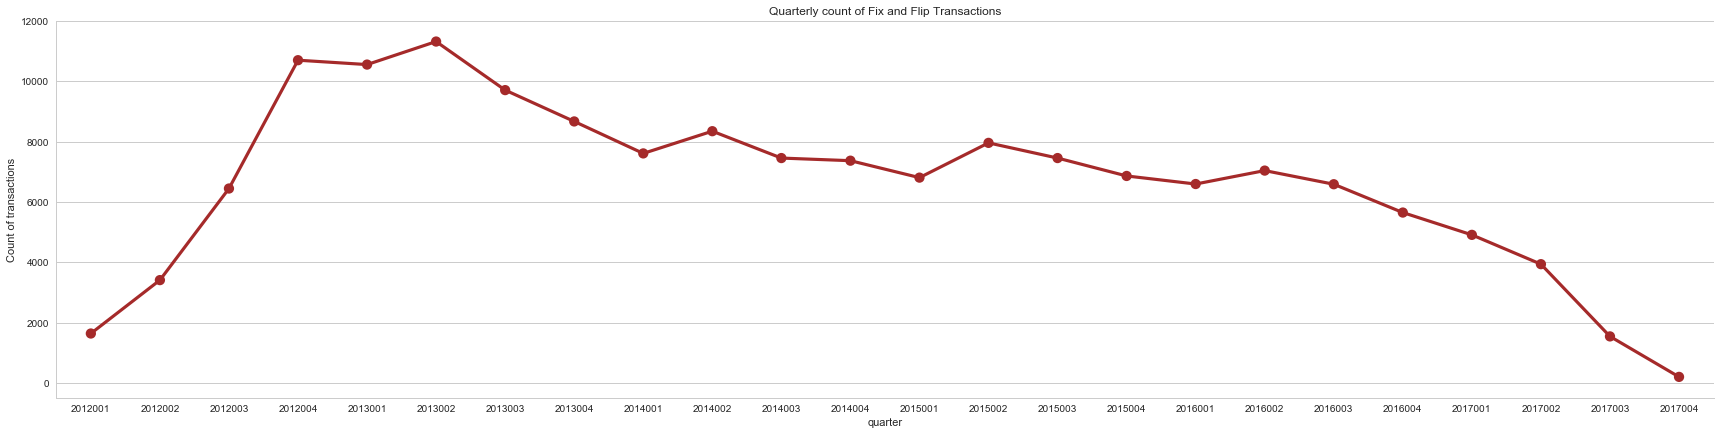

In [42]:
x = overall_data.groupby('quarter')['transaction_amount'].count().reset_index()
sns.set_style("whitegrid")
sns.factorplot(x='quarter',y='transaction_amount',data=x,size=6,aspect=4,ci=None,color='Brown')
plt.title('Quarterly count of Fix and Flip Transactions');
plt.ylabel('Count of transactions');

### Regional level  overview

In [43]:
overall_data.groupby('region')['property_id'].nunique().reset_index()

,region,property_id
0,Bay Area,11421
1,Central Coast,1338
2,Central Sierra,301
3,Greater Sacramento,7243
4,Northern California,570
5,Northern Sacramento Valley,848
6,Other,63914
7,San Joaquin Valley,6976
8,Southern California,62919


In [44]:
property_dist_region = pd.pivot_table(overall_data,index=['region'],values='loan_amount',\
                                      columns=['quarter'],aggfunc=np.sum)

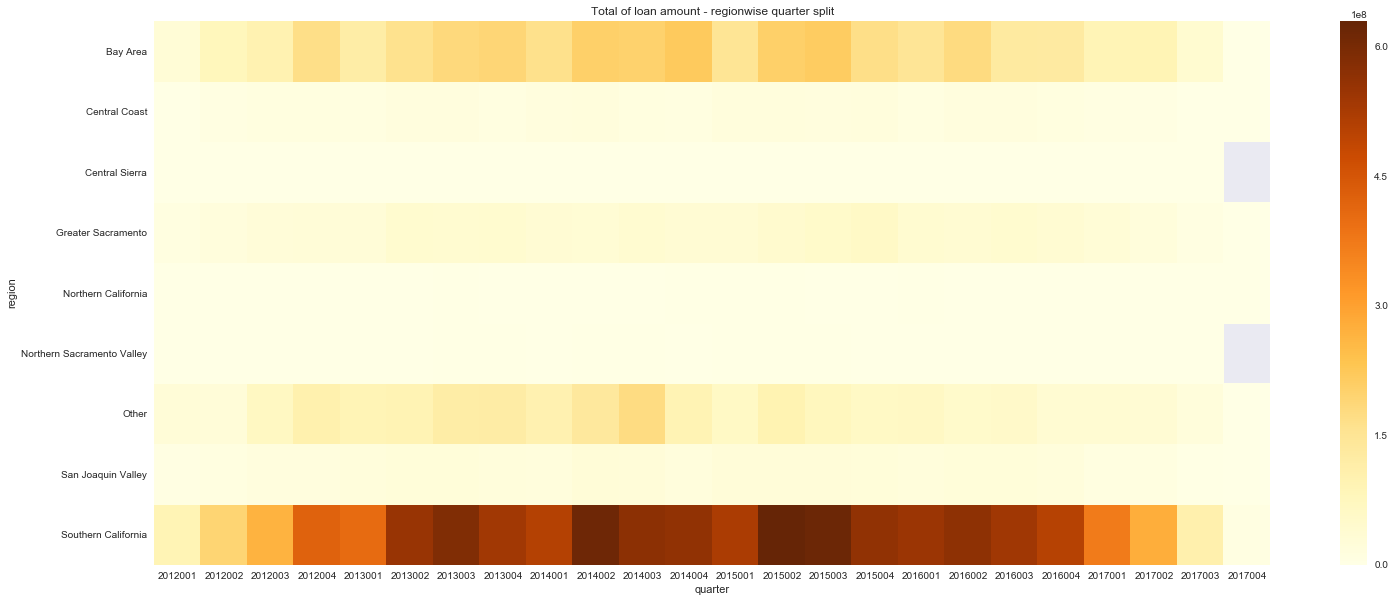

In [45]:
plt.figure(figsize=(25,10))
with sns.axes_style('darkgrid'):
    sns.heatmap(property_dist_region,cmap='YlOrBr')
    plt.title('Total of loan amount - regionwise quarter split')

### Extracting the Undiclosed and Other Institutional Lenders

In [46]:
undisc_lenders = overall_data.loc[overall_data.lender == '* Undisclosed']

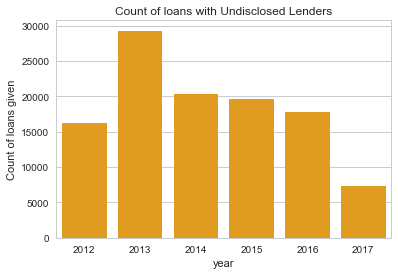

In [47]:
output = undisc_lenders.groupby('year')['transaction_amount'].count().reset_index()
sns.barplot(x='year',y='transaction_amount',data=output,color='Orange')
plt.title('Count of loans with Undisclosed Lenders')
plt.ylabel('Count of loans given')

In [48]:
other_lenders = overall_data.loc[overall_data.lender == '* OTHER INSTITUTIONAL LEN']

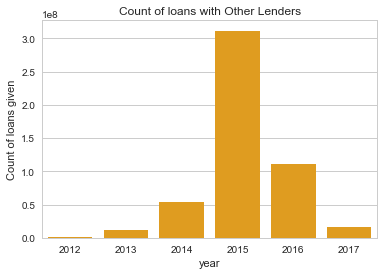

In [49]:
output = other_lenders.groupby('year')['transaction_amount'].sum().reset_index()
sns.barplot(x='year',y='transaction_amount',data=output,color='Orange')
plt.title('Count of loans with Other Lenders')
plt.ylabel('Count of loans given')

In [50]:
sns.set_palette('YlOrBr')

In [51]:
property_type_dist = overall_data.groupby('property_type')['property_id'].nunique().reset_index()

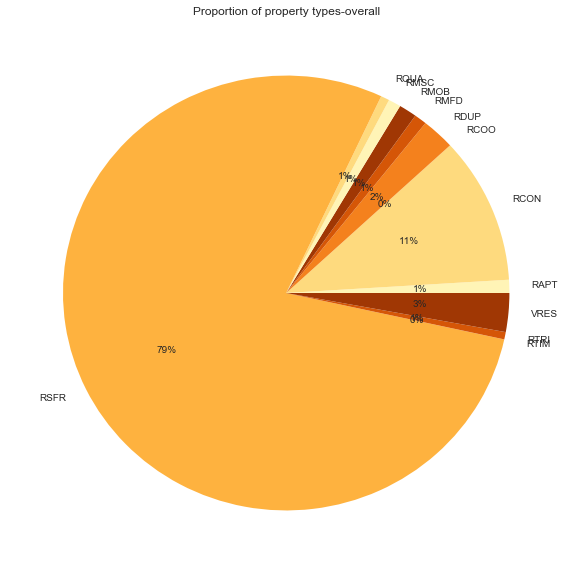

In [52]:
labels = property_type_dist.property_type.tolist();
sizes = property_type_dist.property_id.tolist();
plt.figure(figsize=(10,10))
plt.pie(sizes,  labels=labels,autopct='%1.0f%%',  startangle=0);
plt.title('Proportion of property types-overall')

## Extracting LendingHome data

In [53]:
lh_data = overall_data.loc[overall_data.lender=='LendingHome'].copy()

In [54]:
lh_data.head()

,property_id,transaction_amount,loan_amount,buyer,lender,transaction_date,property_type,property_address,seller,year_built,...,month,year,month_year,quarter,loan_brackets,LTT,city,county,region,is_company
314,26295068,255000,300000.0,APOLLO REALTY INVESTMENTS LLC,LendingHome,2014-12-19,RSFR,5866 CERVANTES AVE SAN DIEGO CA 92114,"GUEVARRA,ERNESTO C",1984,...,12,2014,2014012,2014004,"250,001 to 500,000",1.176471,San Diego,San Diego,Southern California,1
315,26453551,162500,176200.0,"BENITES,LUIS",LendingHome,2015-01-07,RSFR,551 S PAMPAS AVE RIALTO CA 92376,"MCCORMICK,LAURA",1958,...,1,2015,2015001,2015001,"< 250,000",1.084308,Rialto,San Bernardino,Southern California,0
345,26943089,63000,97000.0,YHAZIRHA INVESTMENTS LLC,LendingHome,2015-10-28,RSFR,11147 MORONGO WAY MORONGO VALLEY CA 92256,FEDERAL NATL MTG ASSN FNMA,1954,...,10,2015,2015010,2015004,"< 250,000",1.539683,Morongo Valley,San Bernardino,Southern California,1
371,24595207,452000,406500.0,EQUITY TRUST CO LLC,LendingHome,2016-08-08,RSFR,2120 HIDDEN VALLEY DR SANTA ROSA CA 95404,HEGARDT TERRA L TRUST,1963,...,8,2016,2016008,2016003,"250,001 to 500,000",0.899336,Santa Rosa,Sonoma,Bay Area,1
388,26037017,225000,200000.0,ARDGLASS INVESTMENTS LLC,LendingHome,2016-12-30,RCON,8420 FANITA DR #30 SANTEE CA 92071,"FEISTEL,DANIEL A & NAOMI A B",1980,...,12,2016,2016012,2016004,"< 250,000",0.888889,Santee,San Diego,Southern California,1


### Finding out quarterly loan counts at region level for LendingHome

In [55]:
region_lh_table = pd.pivot_table(lh_data, values='loan_amount', index=['region'],columns=['quarter'], aggfunc=np.sum)

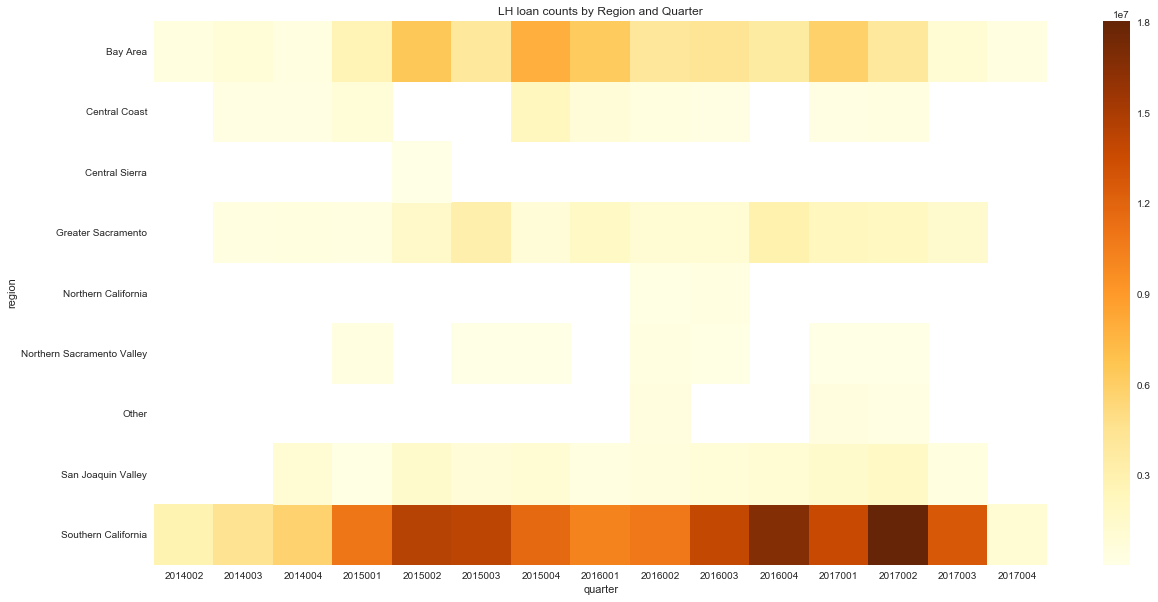

In [56]:
plt.figure(figsize=(20,10))
sns.heatmap(region_lh_table,cmap='YlOrBr')
plt.title('LH loan counts by Region and Quarter')

#### Extracting single transaction buyers for LendingHome

In [57]:
group = lh_data.groupby('buyer')['loan_amount'].count().reset_index()

single_time_buyers = group.buyer.loc[group.loan_amount == 1]

In [58]:
single_time_buyers = single_time_buyers.tolist()

In [59]:
def single_buyer_flag(x):
    '''A function to flag LendingHome single transaction buyers'''
    if x.buyer in single_time_buyers:
        return 1
    else:
        return 0

In [60]:
lh_data['single_time_buyer'] = lh_data.apply(lambda x: single_buyer_flag(x),axis=1)

### Finding the days between transaction for repeat LendingHome borrowers

In [61]:
repeat_buyer_lh_data = lh_data.loc[lh_data.single_time_buyer == 0].copy()

In [62]:
repeat_buyer_days_diff = repeat_buyer_lh_data.groupby(['buyer','transaction_datetime'])\
                            ['transaction_amount'].sum().reset_index()

In [63]:
repeat_buyer_days_diff['days_between_transactions'] = repeat_buyer_days_diff.groupby(['buyer'])\
        ['transaction_datetime'].diff()/np.timedelta64(1,'D')
repeat_buyer_days_diff.dropna(inplace=True)

In [64]:
# Average time between transactions for a repeat buyer
print('Average time between transactions for a repeat buyer: ',\
          repeat_buyer_days_diff.days_between_transactions.mean())

Average time between transactions for a repeat buyer:  83.00271002710028


The buyer with the highest break between transactions with LendingHome

In [65]:
repeat_buyer_days_diff.buyer.loc[repeat_buyer_days_diff.days_between_transactions == \
                                 repeat_buyer_days_diff.days_between_transactions.max()]

29    APOLLO REALTY INVESTMENTS LLC
Name: buyer, dtype: object

In [66]:
print('% of buyers who are investment firms: ',lh_data.is_company.sum()/len(lh_data)* 100)

% of buyers who are investment firms:  84.71502590673575


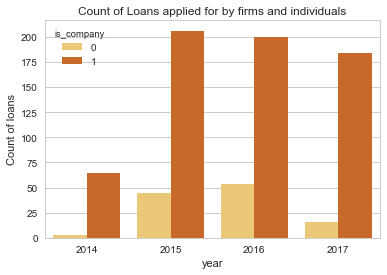

In [67]:
sns.set_style('whitegrid')
sns.barplot(x='year',y='loan_amount',hue='is_company',data=lh_data,ci=None,palette='YlOrBr',estimator=len)

plt.title('Count of Loans applied for by firms and individuals')
plt.ylabel('Count of loans')

Finding out the count of transactions with investment firms and what loan brackets they fall into

In [68]:
company_brackets = lh_data.loc[lh_data.is_company==1]
pd.pivot_table(company_brackets,index=['year'],values=['loan_amount'],\
               columns=['loan_brackets'],aggfunc=len,margins=True)

loan_amount                                        \
loan_brackets 1,000,001 to 1,500,000 250,001 to 500,000 500,001 to 750,000   
year                                                                         
2014                             NaN               20.0                6.0   
2015                             2.0               89.0               23.0   
2016                             2.0               86.0               16.0   
2017                             4.0               70.0               23.0   
All                              8.0              265.0               68.0   

                                                                 
loan_brackets 750,001 to 1,000,000 < 250,000 > 1,500,000    All  
year                                                             
2014                           NaN      38.0         NaN   64.0  
2015                          15.0      76.0         1.0  206.0  
2016                           9.0      86.0         1.0  200.0  
2017                           5.0      81.0         1.0  184.0  
All                           29.0     281.0         3.0  654.0

Investment firms have borrowed loans from mainly the < 250,000 and the 250,000 - 500,000 bracket

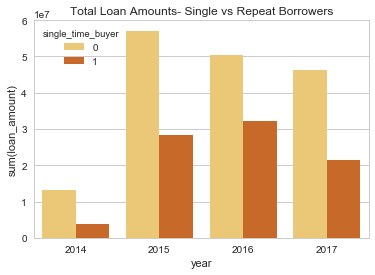

In [69]:
sns.barplot(x='year',y='loan_amount',hue='single_time_buyer',data=lh_data,ci=None,palette='YlOrBr',estimator=sum)
plt.title('Total Loan Amounts- Single vs Repeat Borrowers');

In [70]:
print('% of total loan amount of repeat borrowers: ',lh_data.loan_amount.loc[lh_data.single_time_buyer==0].\
      sum()/lh_data.loan_amount.sum() * 100)

% of total loan amount of repeat borrowers:  66.03580658705616


#### Extracting the top 10 borrowers of LendingHome

In [71]:
lh_data.groupby('buyer')['loan_amount'].sum().sort_values(ascending=False).head(10)

buyer
KARMA CAPITAL LLC                13511062.0
REO CAPITAL FUND 4 LLC           11279300.0
NEXT LEVEL PROPERTY INVS LLC      7306600.0
APOLLO REALTY INVESTMENTS LLC     6937955.0
TWO WEEKS INC                     6862300.0
FPB WEST HOLDINGS INC             5135900.0
GF SERVICES LLC                   4295300.0
CANTER GROUP                      3562700.0
ACROPOLIS CAPITAL LLC             3429100.0
SVDEV I LLC                       3225600.0
Name: loan_amount, dtype: float64

In [72]:
top_buyers_lh = ['KARMA CAPITAL LLC','REO CAPITAL FUND 4 LLC','NEXT LEVEL PROPERTY INVS LLC',
                 'APOLLO REALTY INVESTMENTS LLC', 'TWO WEEKS INC','FPB WEST HOLDINGS INC','GF SERVICES LLC',
                 'CANTER GROUP','ACROPOLIS CAPITAL LLC','SVDEV I LLC']

In [73]:
top_buyers_lh_data = lh_data.loc[lh_data.buyer.isin(top_buyers_lh)].copy()

In [74]:
top_buyers_table = pd.pivot_table(top_buyers_lh_data, values='loan_amount', index=['buyer'],\
                       columns=['quarter'], aggfunc=np.sum)

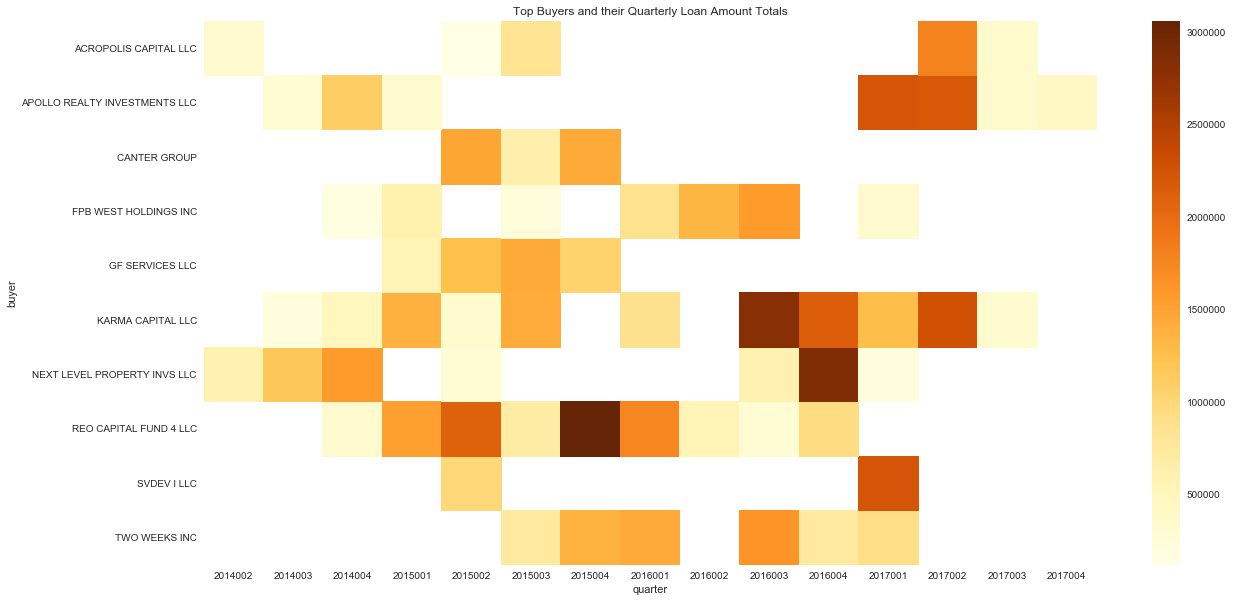

In [75]:
plt.figure(figsize=(20,10))
sns.heatmap(top_buyers_table,cmap='YlOrBr')
plt.title('Top Buyers and their Quarterly Loan Amount Totals')

In [76]:
print('% Contribution of top borrowers to LendingHome total amount: ',top_buyers_lh_data.loan_amount.\
                  sum()/lh_data.loan_amount.sum() * 100)

% Contribution of top borrowers to LendingHome total amount:  25.932372191515974


In [77]:
top_buyers_lh_data.groupby('buyer')['loan_amount'].count().sort_values(ascending=False).head(10)

buyer
KARMA CAPITAL LLC                36
REO CAPITAL FUND 4 LLC           27
APOLLO REALTY INVESTMENTS LLC    21
NEXT LEVEL PROPERTY INVS LLC     19
FPB WEST HOLDINGS INC            17
GF SERVICES LLC                  11
TWO WEEKS INC                     9
ACROPOLIS CAPITAL LLC             8
CANTER GROUP                      6
SVDEV I LLC                       4
Name: loan_amount, dtype: int64

## Extracting top lenders from data

In [78]:
overall_data.groupby('lender')['loan_amount'].sum().sort_values(ascending=False).head(10)

lender
Anchor                       899300912.0
Wells Fargo                  669295340.6
* OTHER INSTITUTIONAL LEN    424233089.0
* Undisclosed                415047810.0
Lone Oak                     358406300.0
Chase                        325807265.0
5 Arch                       255800696.0
LendingHome                  252756734.0
Genesis                      232168809.0
FIRST REPUBLIC BK            185743611.0
Name: loan_amount, dtype: float64

In [79]:
top_lenders = ['Anchor','Wells Fargo','Chase','LendingHome','5 Arch','Lone Oak']
top_lender_data = overall_data.loc[overall_data.lender.isin(top_lenders)]

In [80]:
top_lender_data.lender.unique()

array(['Anchor', 'Lone Oak', 'Wells Fargo', '5 Arch', 'Chase',
       'LendingHome'], dtype=object)

### Filtering entries in top lenders' data so that the transaction start from April 2014- when LendingHome's first transactions took place

In [81]:
top_lender_data = top_lender_data.loc[top_lender_data.month_year >= 2014004].copy()

##### Comparing total loan amounts and loan counts of the top lenders

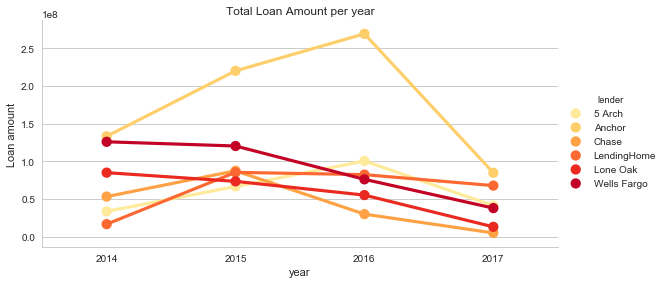

In [82]:
x = top_lender_data.groupby(["year", "lender"], as_index=False).agg({'loan_amount':'sum'})
sns.factorplot(x="year", y="loan_amount", hue="lender", data=x,kind='point',size=4,aspect=2,ci=None,palette='YlOrRd')
plt.title('Total Loan Amount per year')
plt.ylabel('Loan amount')

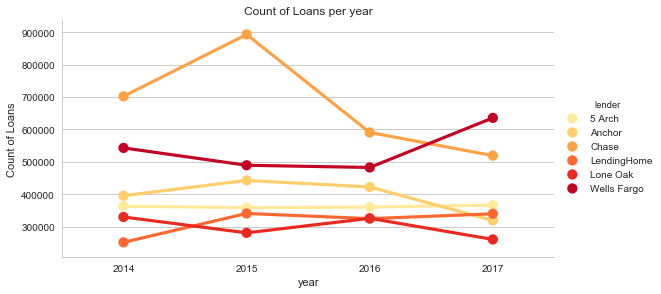

In [83]:
x = top_lender_data.groupby(["year", "lender"], as_index=False).agg({'loan_amount':'mean'})
sns.factorplot(x="year", y="loan_amount", hue="lender", data=x,kind='point',size=4,aspect=2,ci=None,palette='YlOrRd')
plt.title('Count of Loans per year')
plt.ylabel('Count of Loans')

In [84]:
def top_competitors(overall_data,lender):
    lender_data = overall_data.loc[overall_data.lender== lender].copy()
    lender_data = lender_data.loc[lender_data.month_year >= 2014004].copy()
    plt.figure(1)
    sns.factorplot(x='year',y='loan_amount',data=lender_data,estimator=len,ci=None)
    plt.title(lender)
    
    group = lender_data.groupby('buyer')['loan_amount'].count().reset_index()

    single_time_buyers = group.buyer.loc[group.loan_amount == 1]
    
    single_time_buyers = single_time_buyers.tolist()
    
    #checking if the buyer is a single time borrower
    def single_buyer_flag(x):
        if x.buyer in single_time_buyers:
            return 1
        else:
            return 0
    
    #adding single buyer flag
    lender_data['single_time_buyer'] = lender_data.apply(lambda x: single_buyer_flag(x),axis=1)
   
    return lender_data

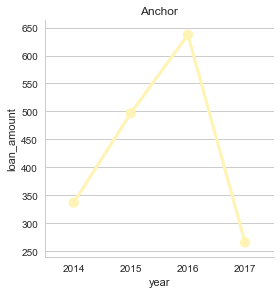

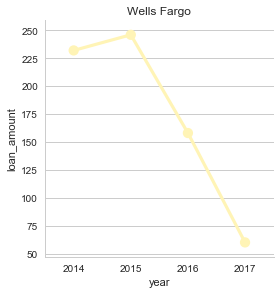

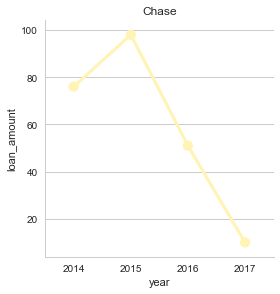

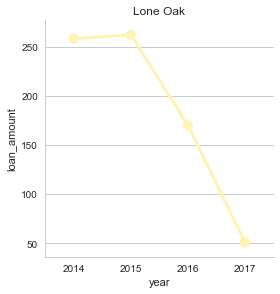

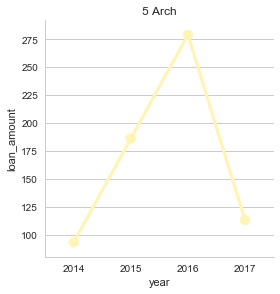

In [85]:
anchor_data = top_competitors(overall_data,'Anchor')
wf_data = top_competitors(overall_data,'Wells Fargo')
chase_data = top_competitors(overall_data,'Chase')
lo_data = top_competitors(overall_data,'Lone Oak')
arch5_data = top_competitors(overall_data,'5 Arch')

In [86]:
def percentage_stack(data,lender): 
    '''Function to obtain the percentage loan count plots for top lenders'''
    loan_counts = pd.pivot_table(data,values=['loan_amount'],\
                        index=['year'],columns=['loan_brackets'],aggfunc=np.sum)

    row_total = np.sum(loan_counts,axis=1)
    table2 = loan_counts.div( row_total, axis=0 ).mul(100)
    table2.plot.bar(stacked=True,colormap='YlOrBr', figsize=(10,11))
    plt.title('Percentage of '+lender +' Loan counts in Loan Brackets')
    plt.ylabel('Percentage of Loan counts')
    plt.legend(bbox_to_anchor=(1.02,0.65), loc="upper left")


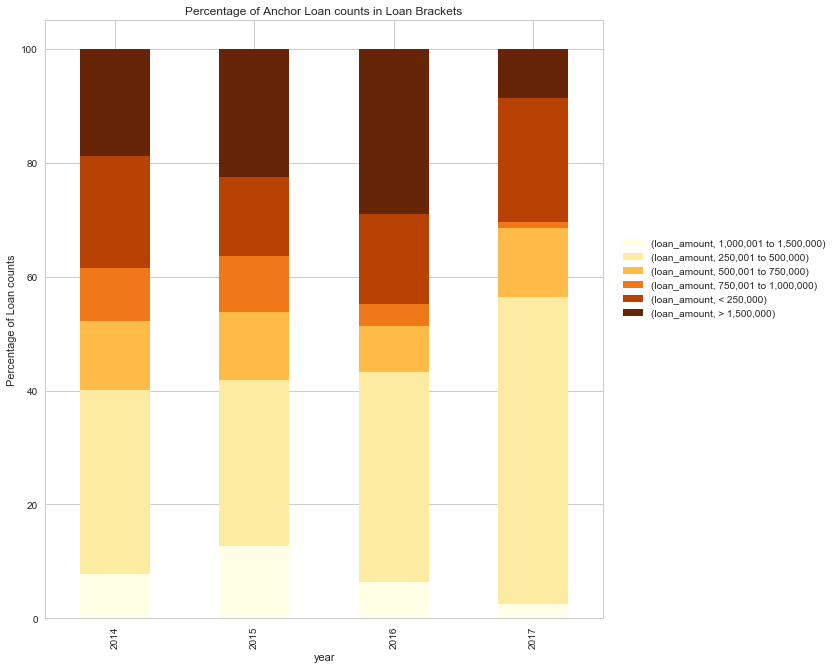

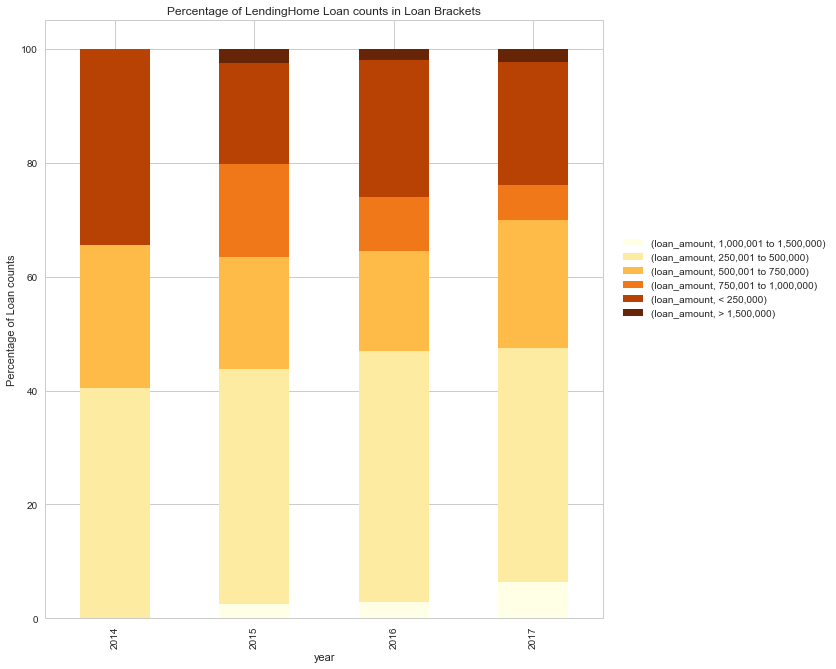

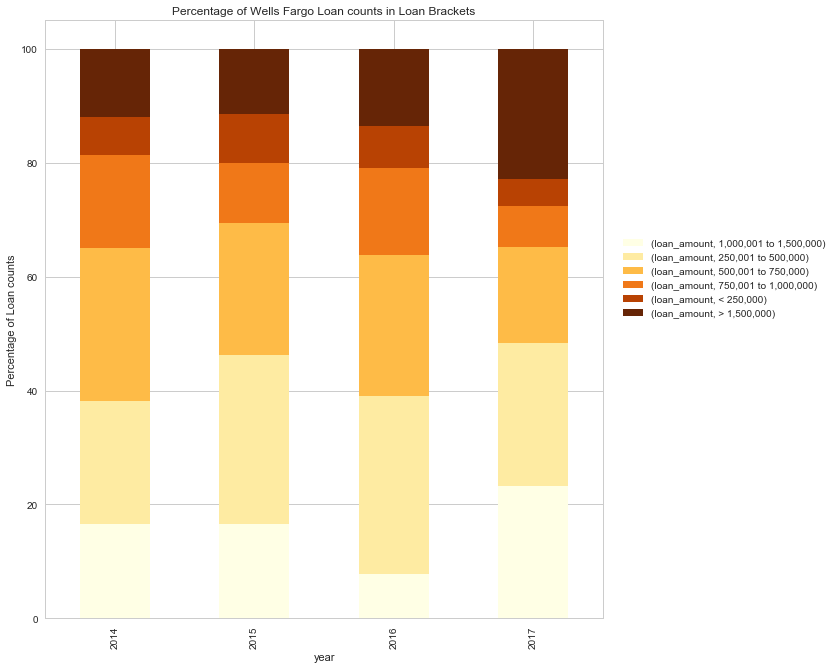

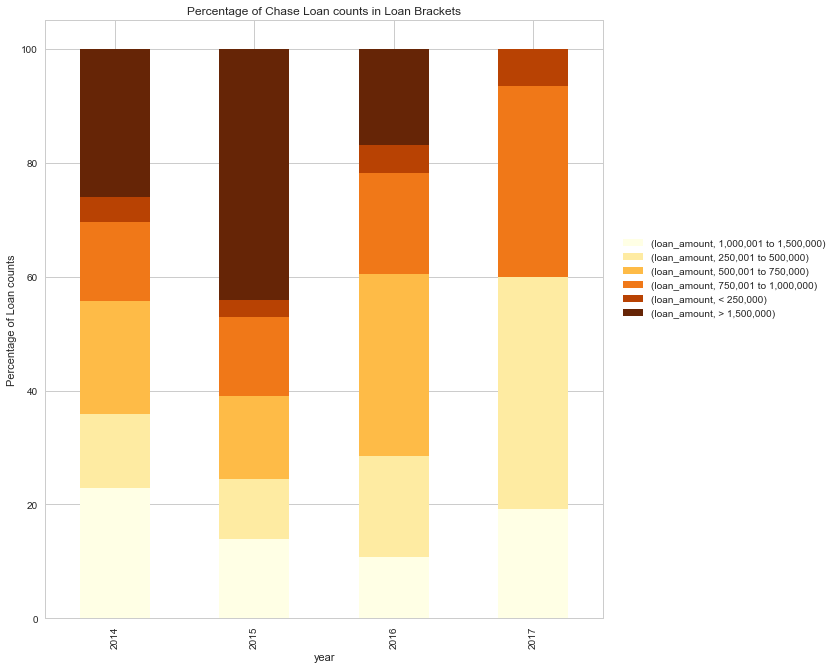

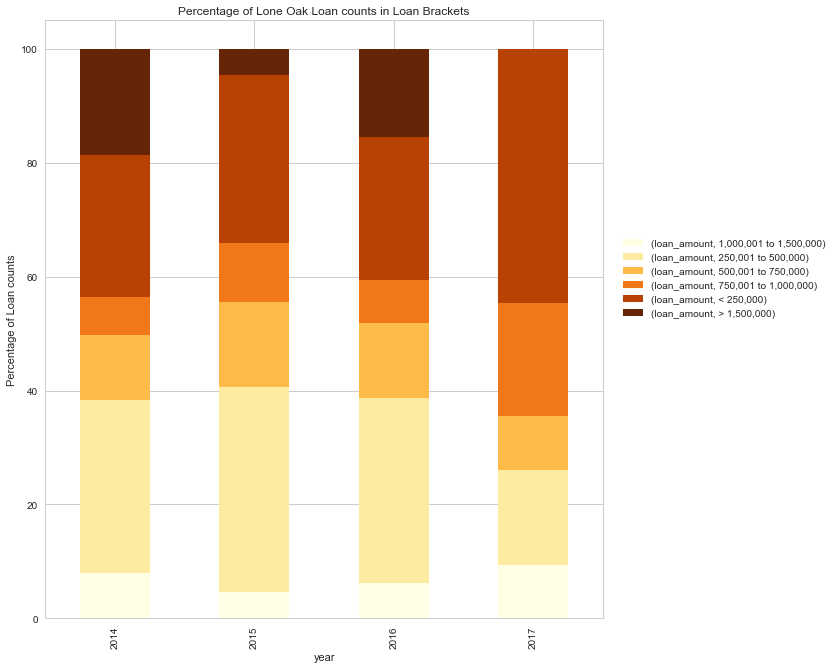

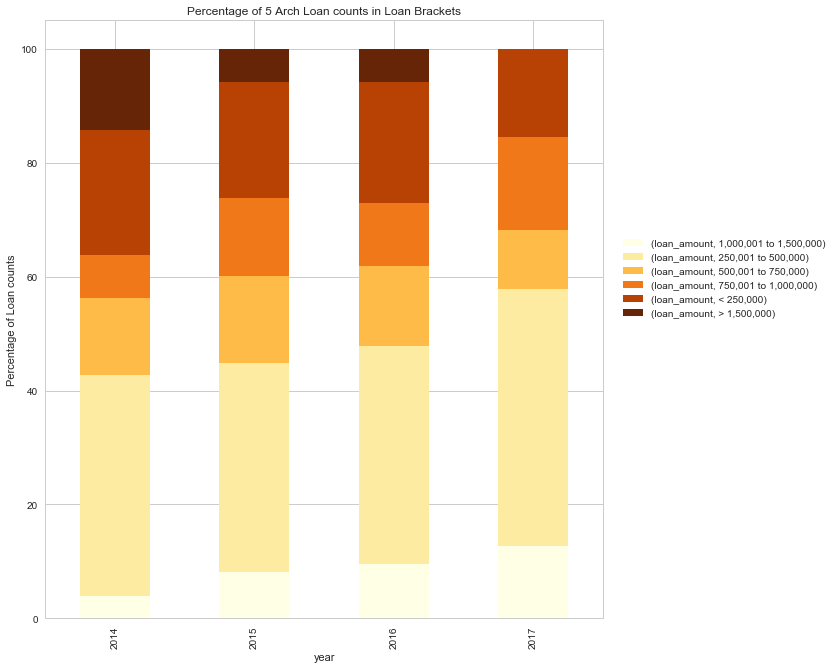

In [87]:
percentage_stack(anchor_data,'Anchor')
percentage_stack(lh_data,'LendingHome')
percentage_stack(wf_data,'Wells Fargo')
percentage_stack(chase_data,'Chase')
percentage_stack(lo_data,'Lone Oak')
percentage_stack(arch5_data,'5 Arch')

In [88]:
def region_comparison(top_lender_data,lender):
    lh_comparison = top_lender_data.loc[(top_lender_data.lender == lender) | \
                        (top_lender_data.lender == 'LendingHome')]

    socal_data = lh_comparison.loc[lh_comparison.region=='Southern California']

    sns.factorplot(x='year',y='loan_amount',hue='lender',data=socal_data,estimator=len,\
                   ci=None,palette='YlOrBr',size=4,aspect=2)
    plt.title('SoCal- '+lender+' vs LH')
    plt.ylabel('Count of loans')
#     plt.savefig(lender+'socal_plot.png',dpi=300,bbox_inches='tight')
    
    not_socal_data = lh_comparison.loc[lh_comparison.region!='Southern California']
    
    sns.factorplot(x='year',y='loan_amount',hue='lender',data=not_socal_data,estimator=len,\
                   ci=None,palette='YlOrBr',size=4,aspect=2)
    plt.title('Other regions- '+lender+' vs LH')
    plt.ylabel('Count of loans')
#     plt.savefig(lender+'no_socal_plot.png',dpi=300,bbox_inches='tight')

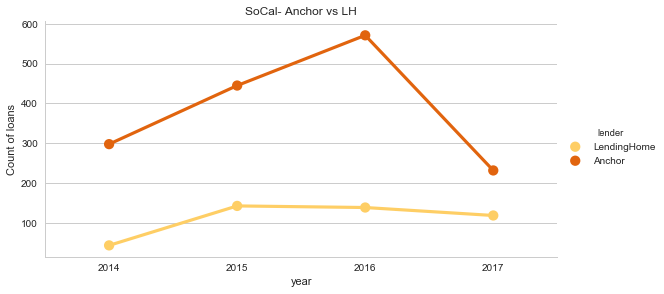

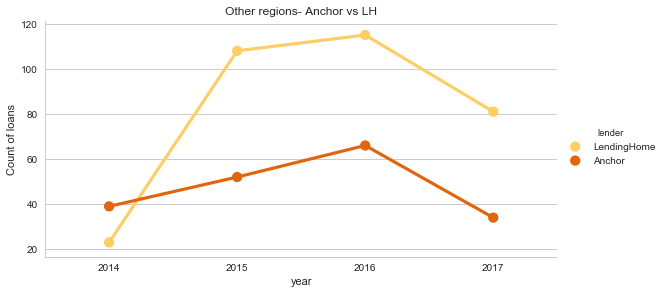

In [89]:
region_comparison(top_lender_data,'Anchor')

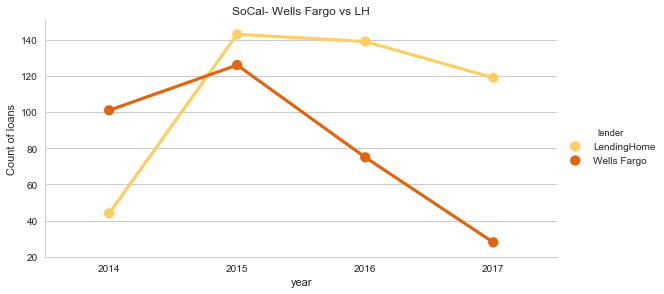

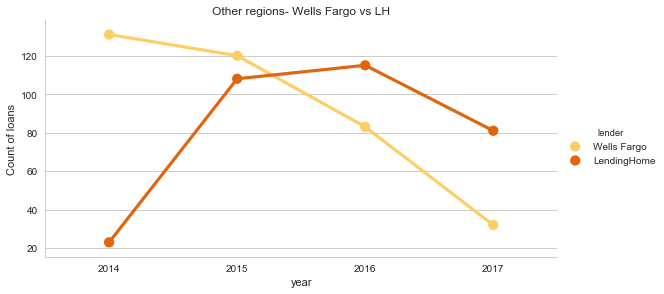

In [90]:
region_comparison(top_lender_data,'Wells Fargo')

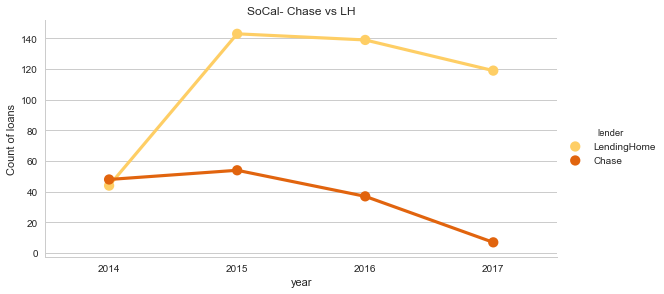

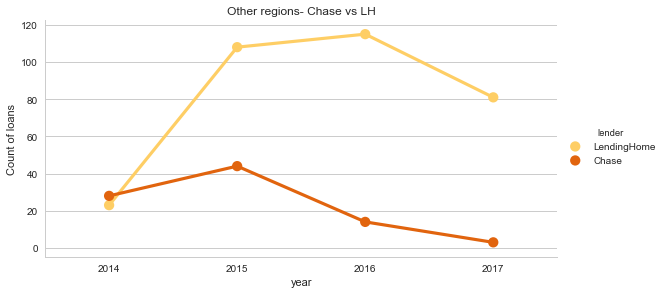

In [91]:
region_comparison(top_lender_data,'Chase')

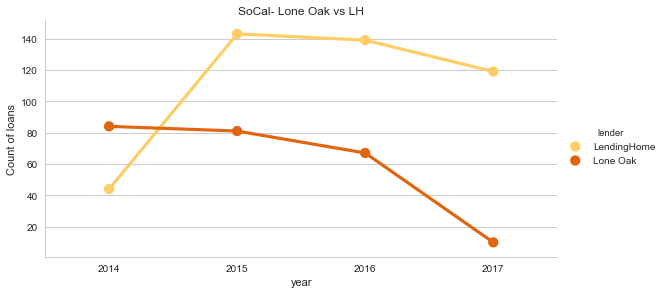

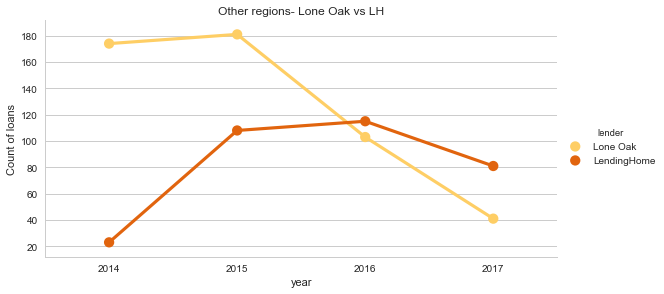

In [92]:
region_comparison(top_lender_data,'Lone Oak')

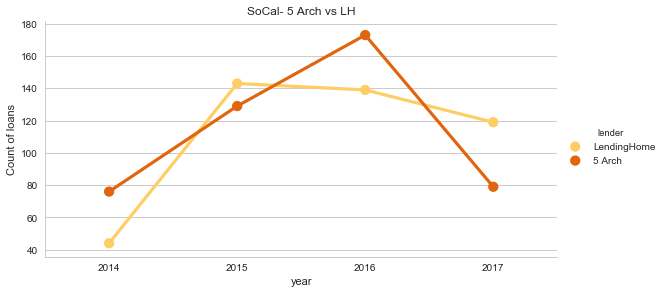

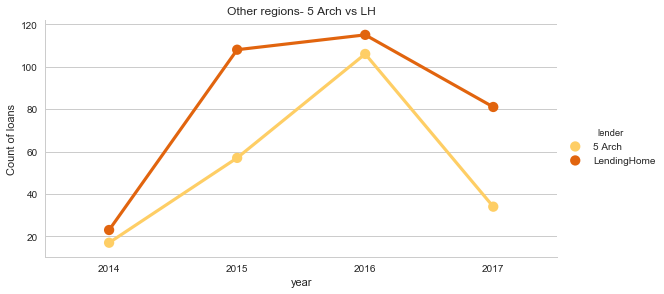

In [93]:
region_comparison(top_lender_data,'5 Arch')

In [94]:
anchor_data.groupby('property_type')['loan_amount'].count()

property_type
RAPT       5
RCON      53
RDUP      70
RMFD       9
RMOB       3
RMSC       3
RQUA      11
RSFR    1560
RTRI      18
VRES       5
Name: loan_amount, dtype: int64

In [95]:
lh_data.groupby('property_type')['property_id'].nunique()

property_type
RCON     46
RDUP     13
RMFD      2
RMOB      1
RQUA      1
RSFR    703
RTRI      2
VRES      4
Name: property_id, dtype: int64

In [96]:
overall_data.columns

Index(['property_id', 'transaction_amount', 'loan_amount', 'buyer', 'lender',
       'transaction_date', 'property_type', 'property_address', 'seller',
       'year_built', 'sqft', 'transaction_datetime', 'zip_code', 'month',
       'year', 'month_year', 'quarter', 'loan_brackets', 'LTT', 'city',
       'county', 'region', 'is_company'],
      dtype='object')

### Single transaction Lenders

In [97]:
lenders_transaction_count = overall_data.groupby('lender')['transaction_amount'].count().reset_index()

In [98]:
single_transaction_lenders = lenders_transaction_count.lender.loc\
                    [lenders_transaction_count.transaction_amount == 1].tolist()

In [100]:
def single_transaction_lender_flag(x):
    if x.lender in single_transaction_lenders:
        return 1
    else:
        return 0

In [101]:
overall_data['single_transaction_lender'] = overall_data.apply(lambda x: single_transaction_lender_flag(x),axis=1)

In [102]:
percentage_lenders = overall_data.groupby('year')['single_transaction_lender','transaction_amount']\
                        .agg({'single_transaction_lender':'sum','transaction_amount':'count'}).reset_index()

In [103]:
percentage_lenders['percent_of_single_transaction_lenders'] = percentage_lenders\
                    ['single_transaction_lender']/percentage_lenders['transaction_amount'] * 100

In [104]:
percentage_lenders

,year,single_transaction_lender,transaction_amount,percent_of_single_transaction_lenders
0,2012,771,22202,3.472660
1,2013,1472,40245,3.657597
2,2014,1410,30781,4.580748
3,2015,1138,29086,3.912535
4,2016,897,25877,3.466399
5,2017,436,10608,4.110106
